In [21]:
import healpy as h
import sys  ; sys.path.append("../../codes/")
#from modules import calc_spinylm as sylm
#from modules import local_eb_kernel as rko
from modules_v2 import euler as euler
from modules_v2 import rs_rad_ker as rk
from modules_v2 import  convert_qu2eb as qb
from modules_v2 import aliasing_correction as ac
from modules_v1 import aliasing_correction as ac1
from scipy.interpolate import interp1d


%pylab notebook
import time

Populating the interactive namespace from numpy and matplotlib


/Users/adityarotti/Library/Enthought/Canopy/edm/envs/User/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [22]:
def get_alm(cl,lmax,seed=0):
    random.seed(seed)
    almsize=h.Alm.getsize(lmax,lmax)
    ar=random.normal(size=almsize)
    ai=random.normal(size=almsize)
    alm=zeros(almsize,complex)
    for i in range(almsize):
        l,m=h.Alm.getlm(lmax,i)
        if m==0:
            alm[i]=complex(ar[i],0.)*sqrt(cl[l])
        else:
            alm[i]=complex(ar[i],ai[i])*sqrt(0.5*cl[l])
    return alm

In [45]:
nside=8 ; npix=h.nside2npix(nside)
sampling=6000
lmax=2*nside

pxsize=sqrt(4.*pi/h.nside2npix(nside))
beta0=min(180,180.*32/(3*nside))*pi/180. ; print beta0*180/pi

theta,pl2=rk.get_plm0(lmax,sampling,theta_max=min(pi,3.*beta0))

180.0


In [46]:
cltemp=h.read_cl("../../data/cl_rem3.fits")
clr=[cltemp[0],cltemp[1],cltemp[2],cltemp[3]*1]

almt=get_alm(clr[0],lmax,1) ; alme=get_alm(clr[1],lmax,2) ; almb=get_alm(clr[2],lmax,3)
true_alm=[almt,alme,almb] ; cltrue=h.alm2cl(true_alm)

tqu=h.alm2map(true_alm,nside,pol=True) ; alm=h.map2alm(tqu,lmax=lmax)
cl=h.alm2cl(alm) ; teb=h.alm2map(alm,nside,pol=False)

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


In [47]:
theta_cutoff=pi

print theta_cutoff/pi, theta_cutoff*180./pi

1.0 180.0


In [48]:
apow=rk.fn_apodization(theta,theta_cutoff=theta_cutoff,apow_frac=0.000001)
rad_ker=rk.calc_qu2eb_rad_ker(lmax,theta,pl2)# Default
rad_ker_i,rad_ker_d=rk.calc_qu2queb_rad_ker(lmax,theta,pl2)

<IPython.core.display.Javascript object>


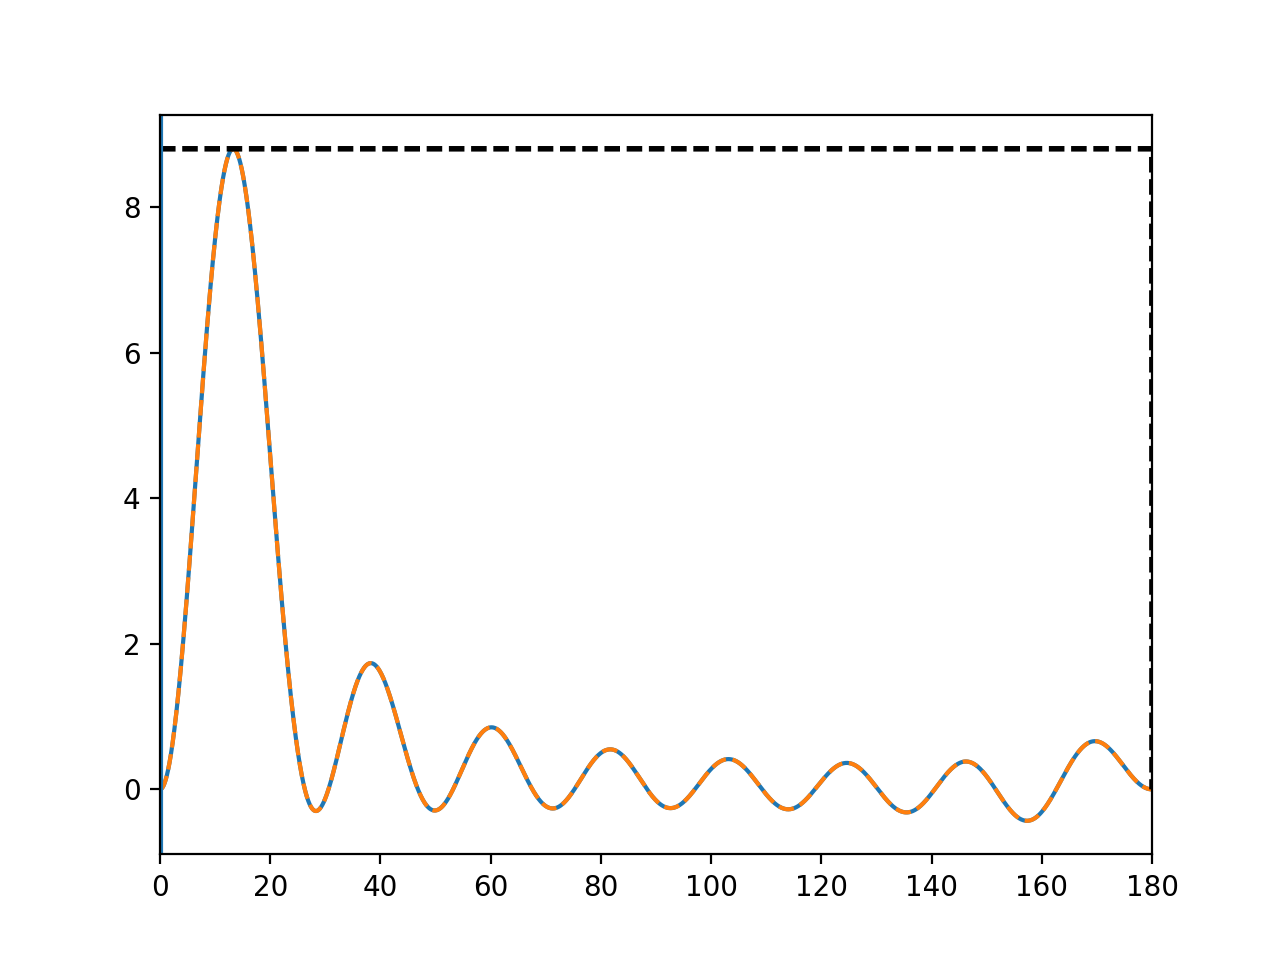

In [49]:
figure()
plot(theta*180./pi,rad_ker)
plot(theta*180./pi,rad_ker*apow,"--")
#plot(theta,rad_ker_i,"--")
plot(theta*180./pi,apow*max(rad_ker),"k--",lw=2)
axvline(pxsize)
xlim(0,theta_cutoff*180./pi)
rad_ker=rad_ker*apow

In [50]:
ell=arange(lmax+1)
gl=rk.get_gl_from_gbeta(theta,rad_ker,pl2,theta_cutoff,lmax) ;# gl[0:2]=1
rec_rad_ker=rk.get_gbeta_from_gl(theta,gl,pl2)

<IPython.core.display.Javascript object>


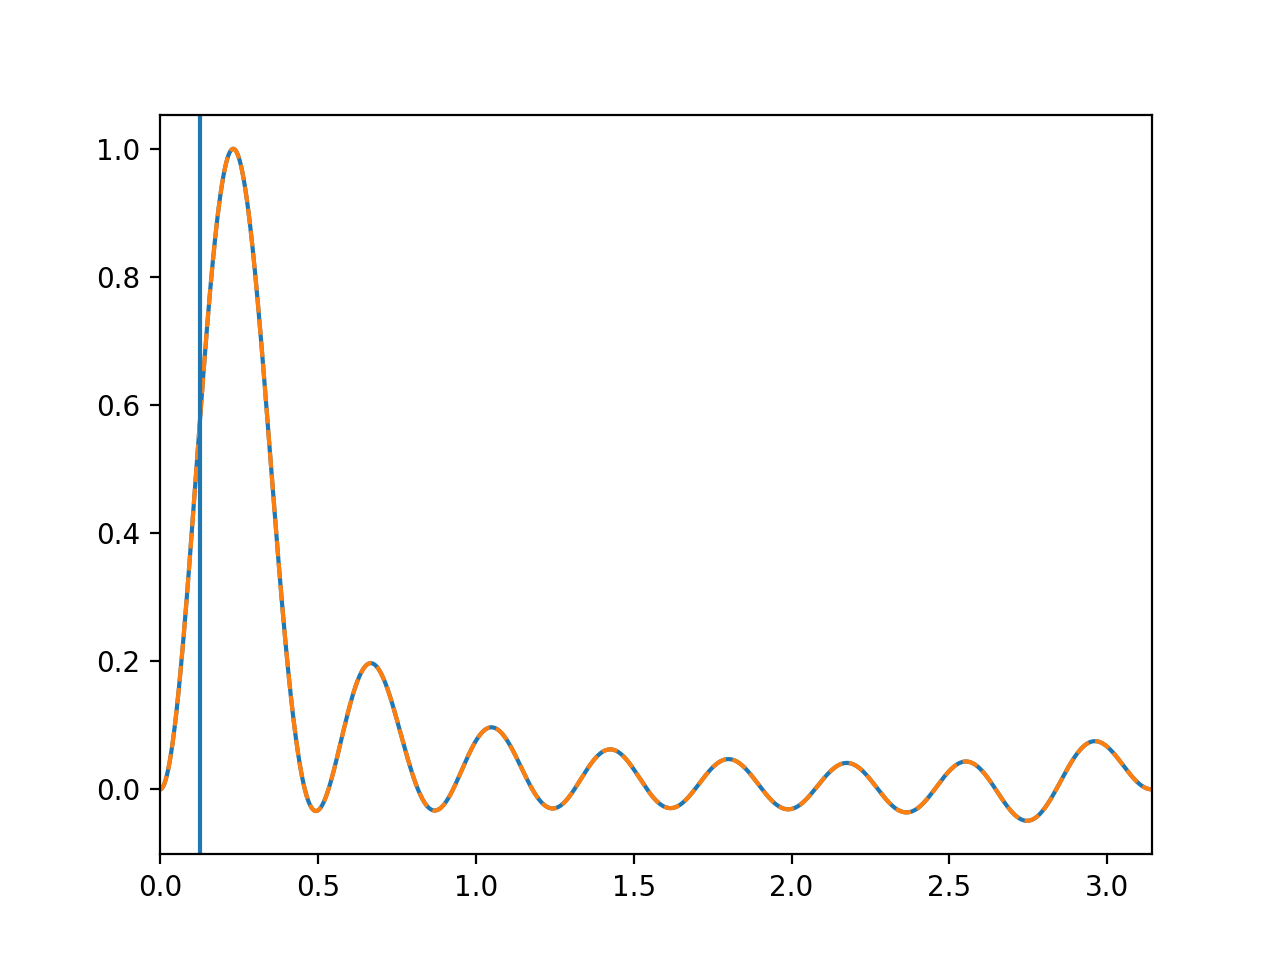

(0, 3.141592653589793)

In [51]:
figure()
plot(theta,rad_ker/max(rad_ker))
plot(theta,rec_rad_ker/max(rec_rad_ker),"--")
axvline(pxsize)
xlim(0,min(pi,1.5*theta_cutoff))

<IPython.core.display.Javascript object>


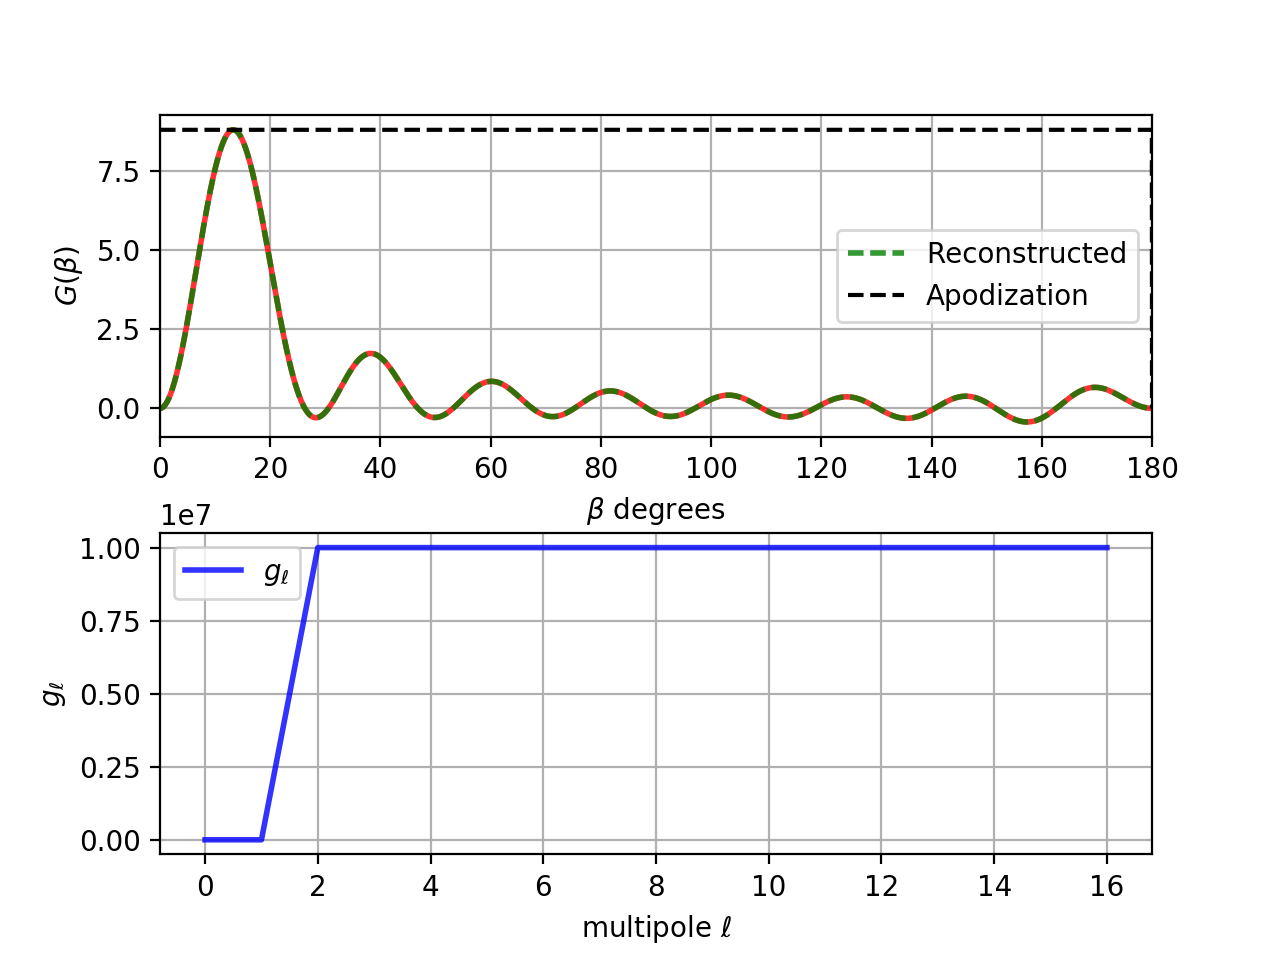

In [52]:
f, (ax1, ax2) = plt.subplots(2, sharex=False, sharey=False)
ax1.plot(theta*180./pi,rad_ker,"r-",lw=2,label="",alpha=0.8)
ax1.plot(theta*180./pi,rec_rad_ker,"g--",lw=2,label="Reconstructed",alpha=0.8)
ax1.plot(theta*180./pi,apow*max(rad_ker),"k--",label="Apodization")
ax1.grid()
ax1.legend(loc=0)
ax1.set_xlim(0,theta_cutoff*180./pi)
ax1.set_xlabel(r"$\beta$ degrees")
ax1.set_ylabel(r"$G(\beta)$")

ax2.plot(ell,gl*1e7,"b-",lw=2,label=r"$g_{\ell}$",alpha=0.8)
ax2.grid()
ax2.legend(loc=0)
ax2.set_xlabel(r"multipole $\ell$")
ax2.set_ylabel(r"$g_{\ell}$")
f.subplots_adjust(hspace=0.3)


In [67]:
def delta_convolve(q,u,theta_cutoff,theta,rad_ker_i,mask=[]):
	fn_rad_ker_i=interp1d(theta,rad_ker_i,assume_sorted=True,kind="cubic",bounds_error=False,fill_value=0.0)
	nside=h.get_nside(q) ; npix=h.nside2npix(nside) ; domega=4.*np.pi/float(npix)

	hq=np.zeros(npix,"double")
	hu=np.zeros(npix,"double")
	
	if np.size(mask)==0:
		pix_list=np.arange(npix)
	else:
		pix_list=np.nonzero(mask)[0]

	# The pixel i is where EQU and BQU are being evaluated.	
	for i in pix_list:
		beta,alpha,gamma,spix=euler.return_euler_angles(nside,i,theta_cutoff,inclusive=True,fact=4)
		gbeta=fn_rad_ker_i(beta)
		Ir=np.cos(2.*(alpha+gamma))*gbeta
		Ii=np.sin(2.*(alpha+gamma))*gbeta

		hq[i]=(np.dot(Ir,q[spix]) + np.dot(-Ii,u[spix]))*domega
		hu[i]=(np.dot(Ii,q[spix]) + np.dot( Ir,u[spix]))*domega

	return hq,hu

def correct_aliasing_convolve(tq,tu,theta_cutoff,theta,rad_ker_i,iter=3,mask=[]):
    npix=np.size(tq)
    cq=np.zeros(npix,"double") ; cu=np.zeros(npix,"double")	
    for i in range(iter+1):
        hq,hu=delta_convolve(tq-cq,tu-cu,theta_cutoff,theta,rad_ker_i,mask)
        cq=cq + (hq-tq) ; cu=cu + (hu-tu)
    return [np.zeros(npix),tq-cq,tu-cu]

In [75]:
hq1,hu1=delta_convolve(tqu[1],tqu[2],pi,theta,rad_ker_i)
cq1=hq1-tqu[1] ; cu1=hu1-tqu[2]

<IPython.core.display.Javascript object>


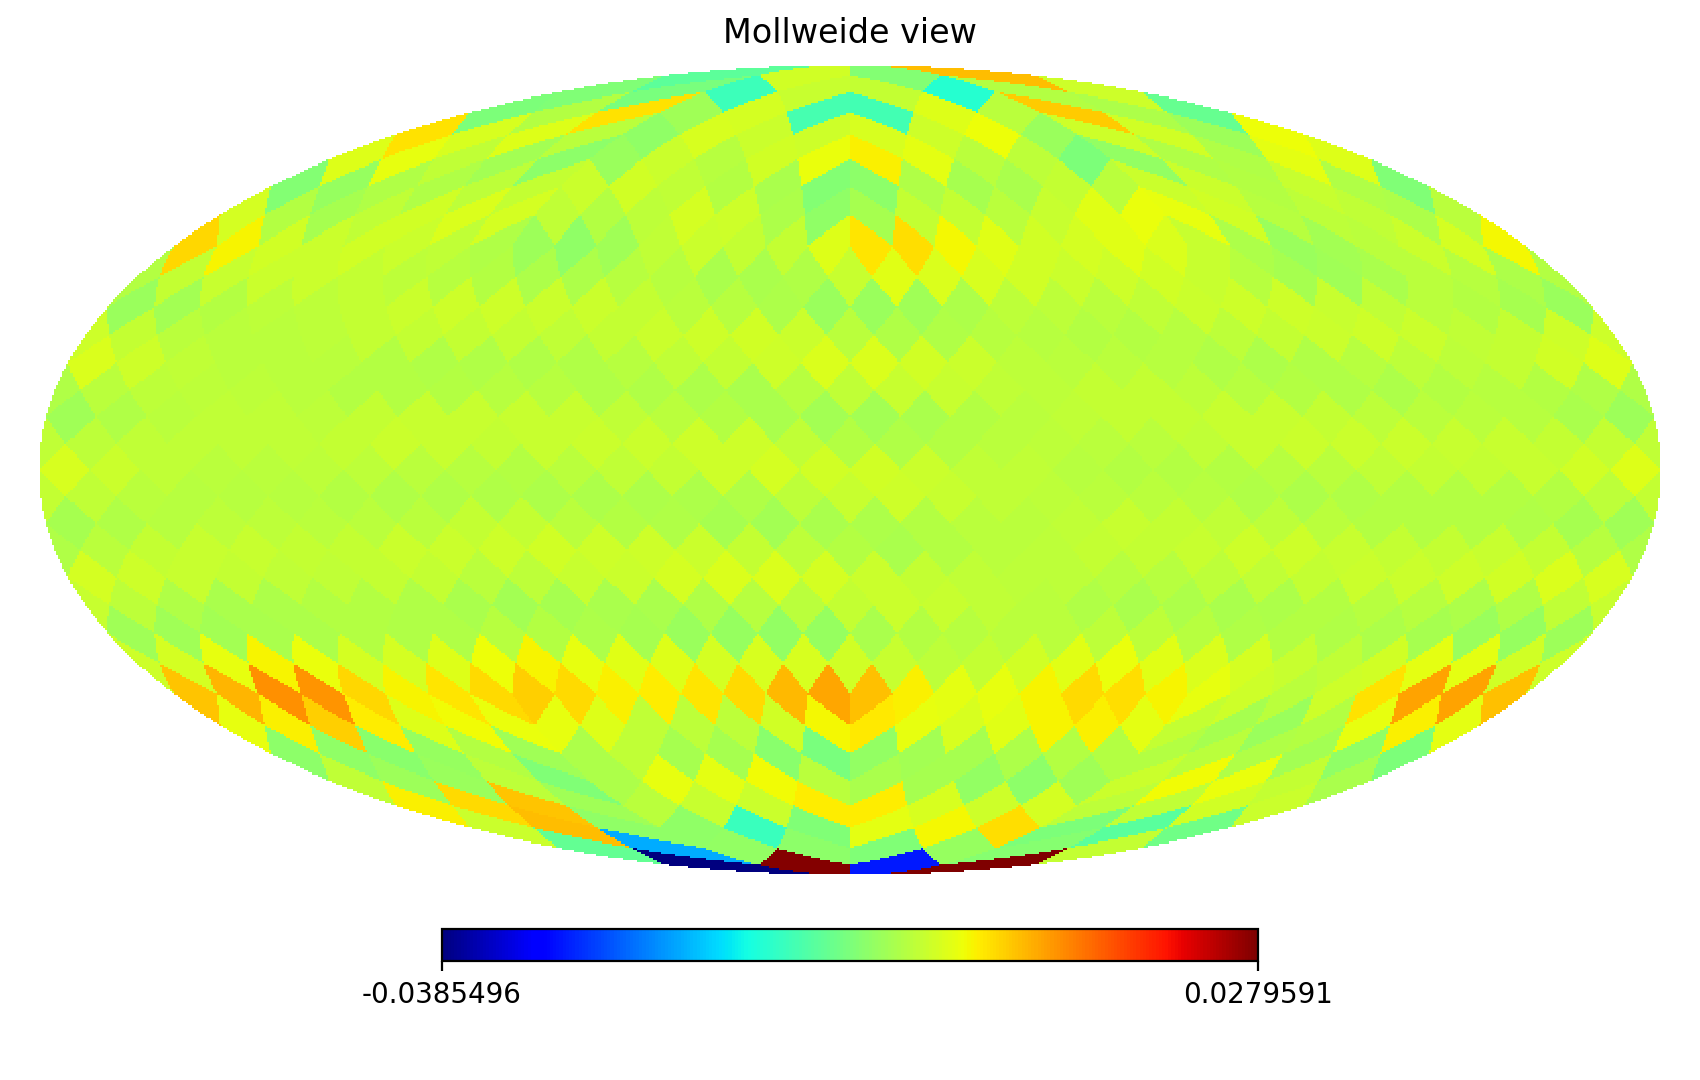

<IPython.core.display.Javascript object>


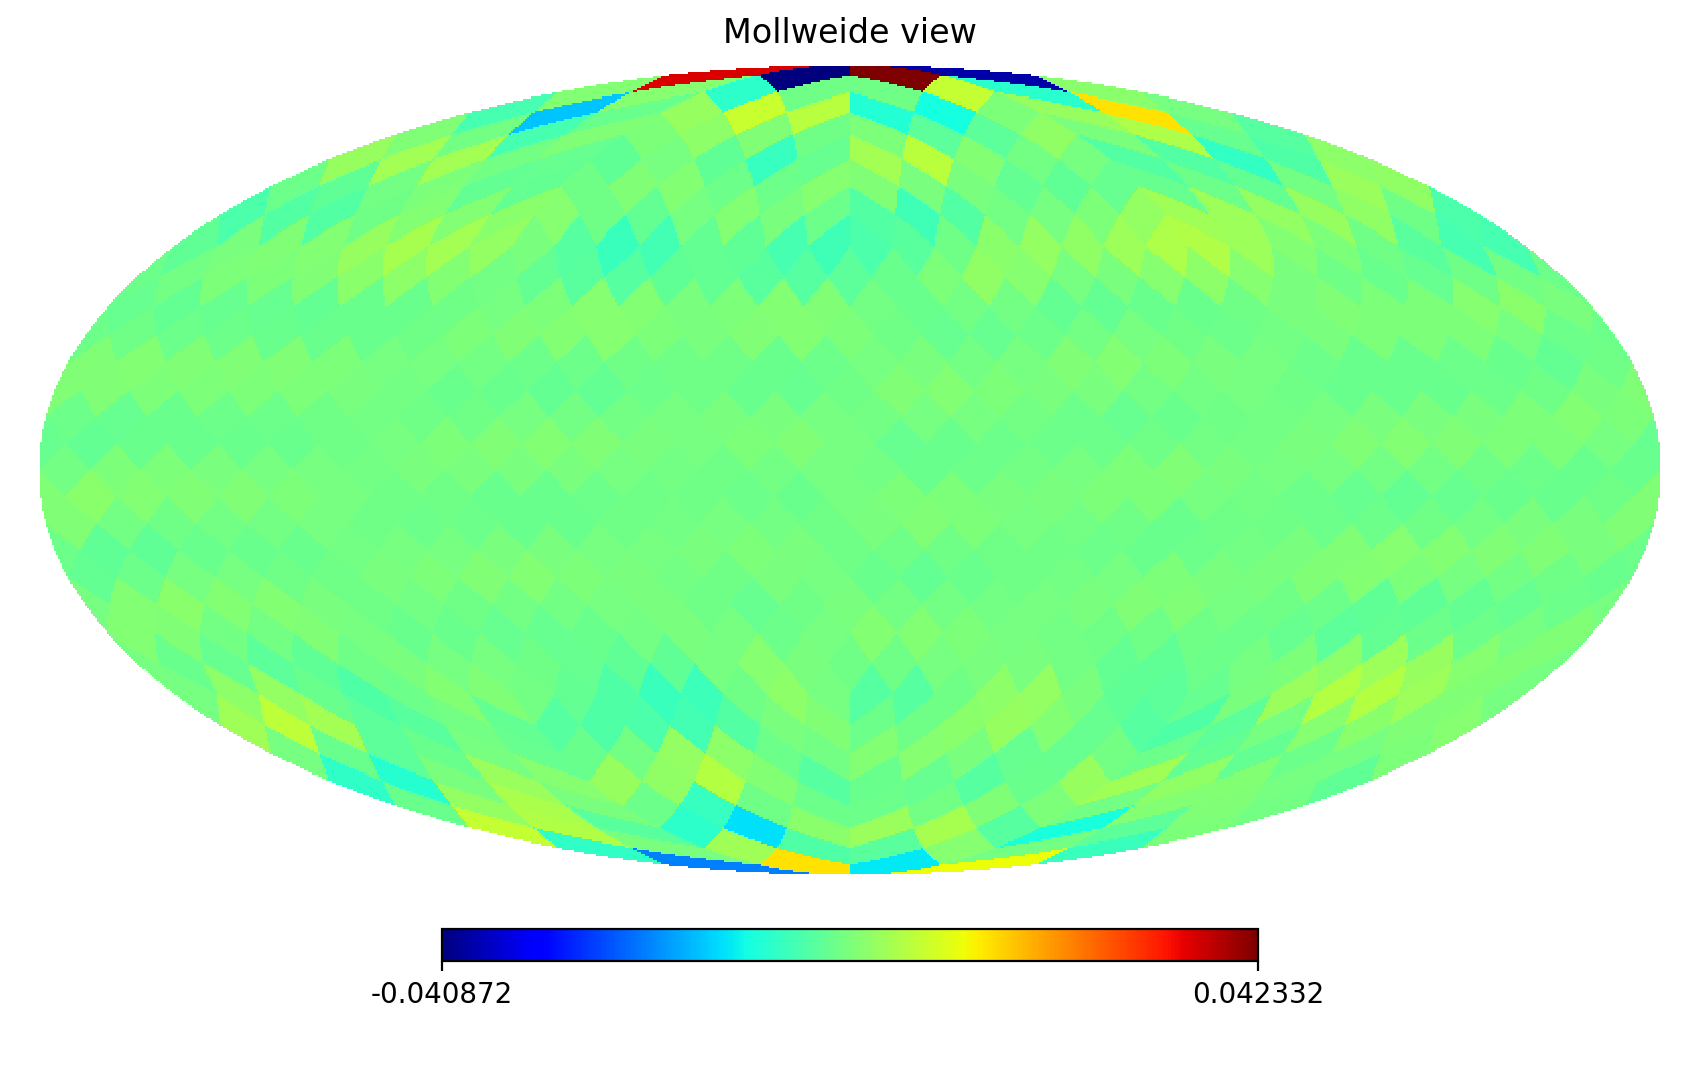

In [80]:
hq2,hu2=delta_convolve(tqu[1]+cq1,tqu[2]+cu1,pi,theta,rad_ker_i)
cq2=hq2-tqu[1] ; cu2=hu2-tqu[2]
h.mollview(cq2)
h.mollview(cu2)

In [70]:
ctqu=correct_aliasing_convolve(tqu[1],tqu[2],theta_cutoff,theta,rad_ker_i,iter=2)
ctqu1=ac1.correct_aliasing_convolve(tqu[1],tqu[2],theta_cutoff,theta,rad_ker_i,iter=3)
ctqu2=h.alm2map(h.map2alm(tqu,lmax=3*nside,iter=2,pol=True),nside)

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


<IPython.core.display.Javascript object>


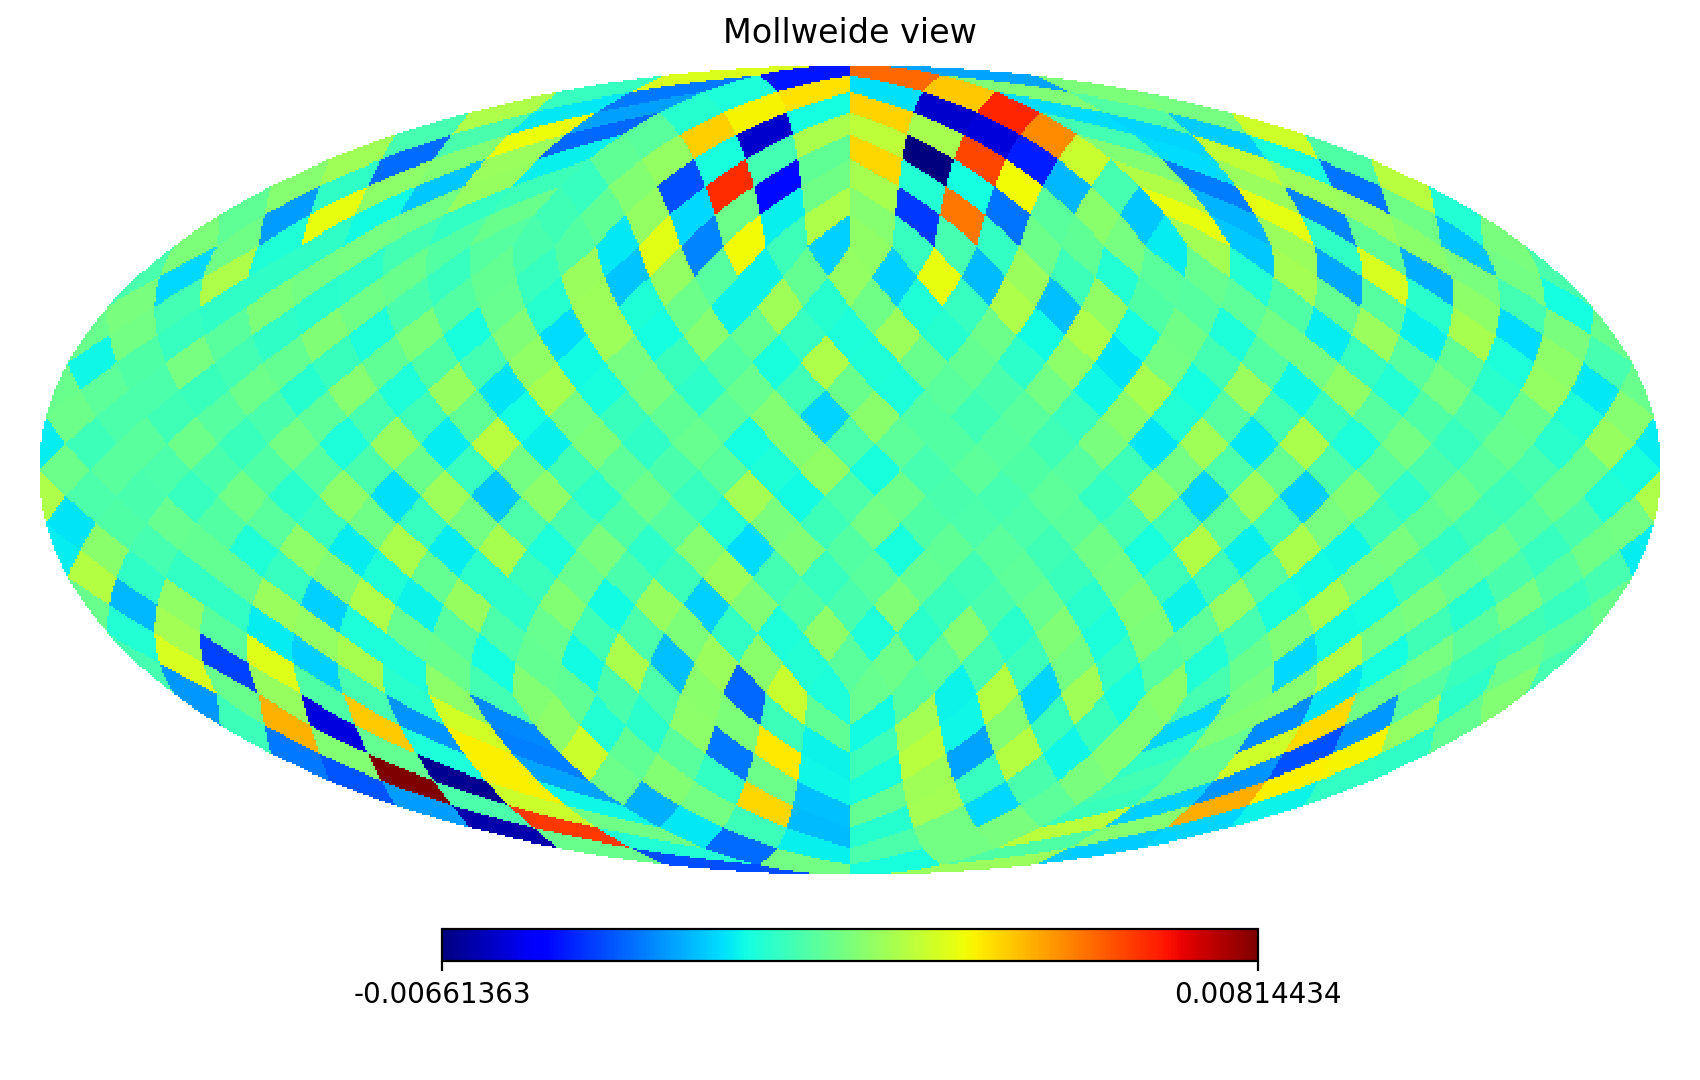

<IPython.core.display.Javascript object>


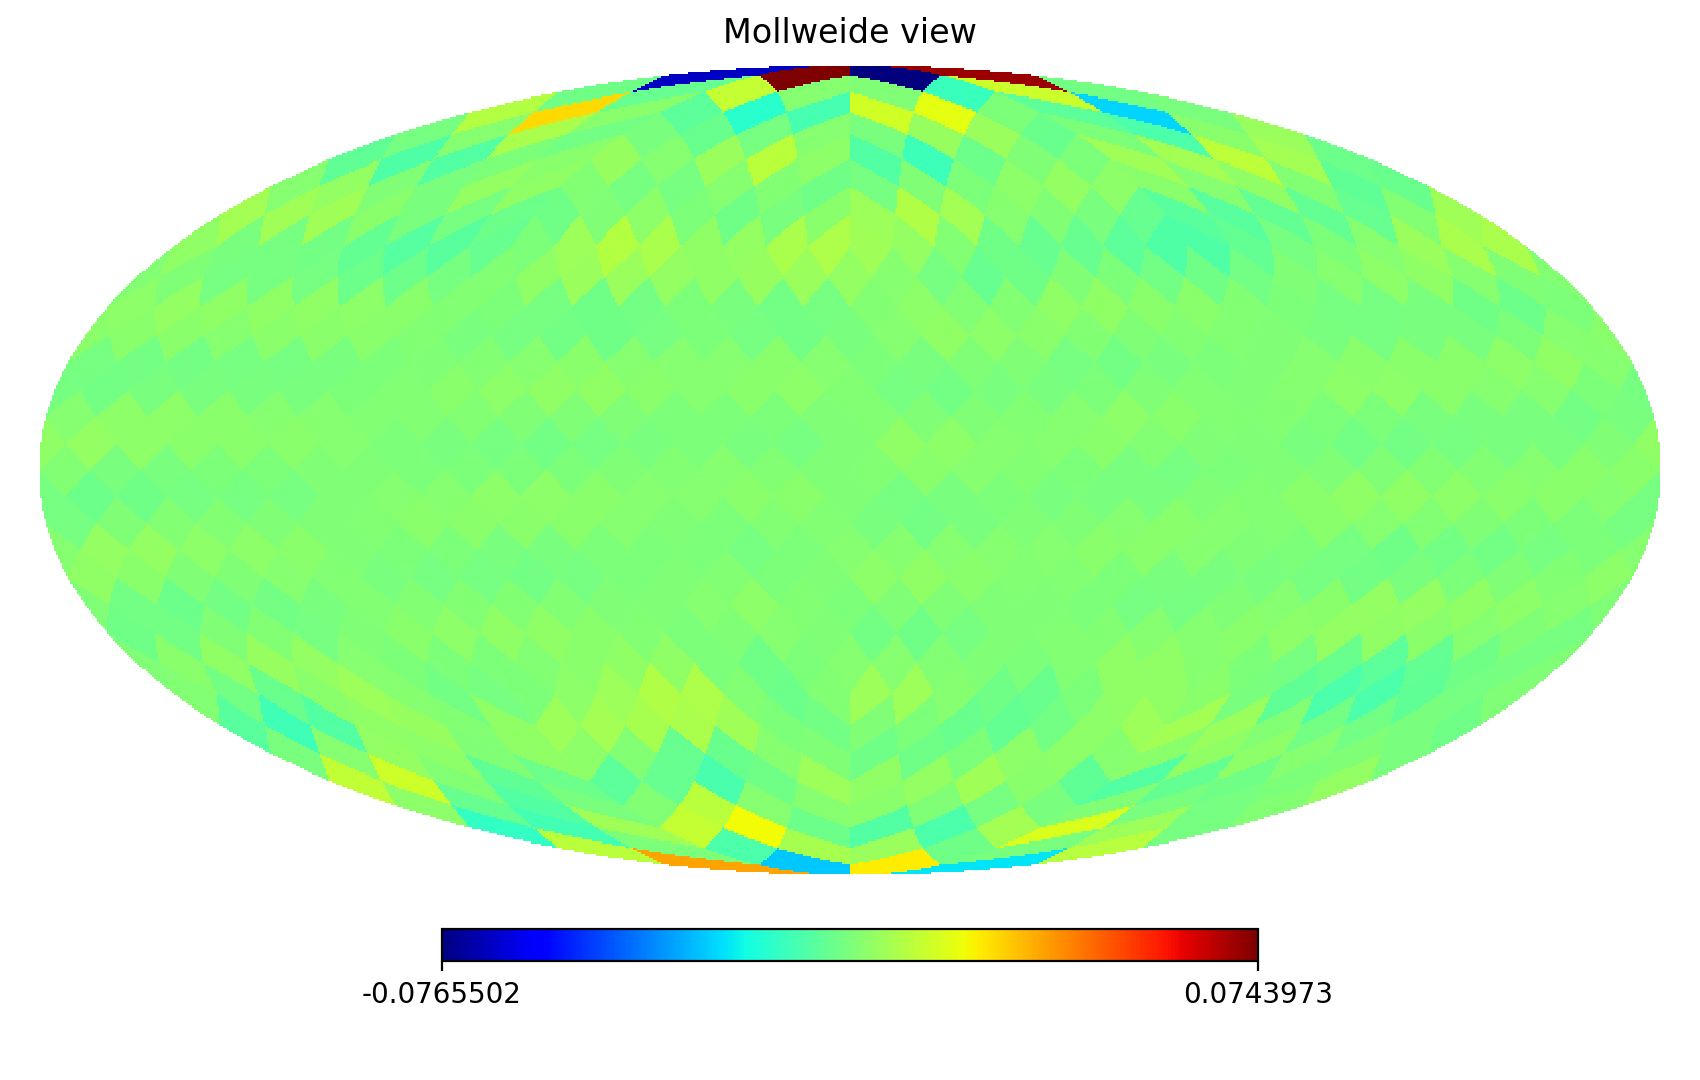

In [71]:
h.mollview(ctqu2[2]-tqu[2])
h.mollview(ctqu[2]-tqu[2])

In [42]:
teb=qb.convert_qu2eb_convolve(ctqu2[1],ctqu2[2],np.pi,theta,rad_ker)
teb2=h.alm2map(h.map2alm(tqu,pol=True,iter=0),nside,pol=False)

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


<IPython.core.display.Javascript object>


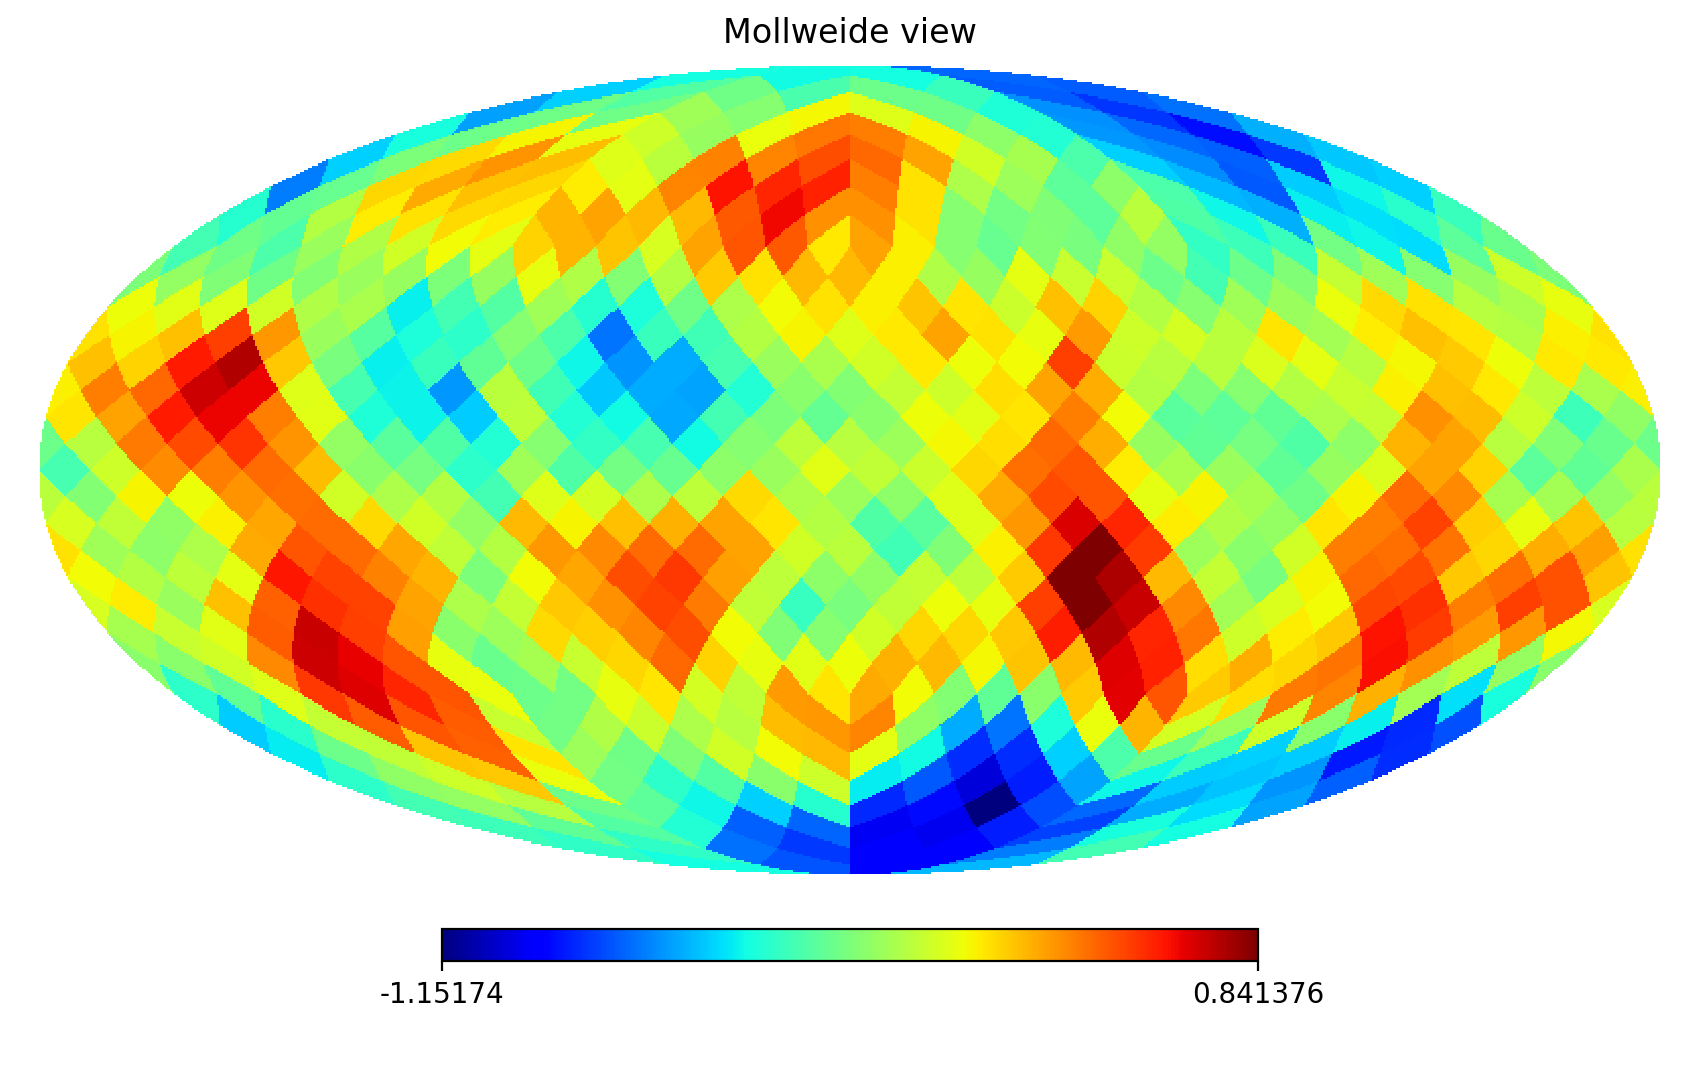

<IPython.core.display.Javascript object>


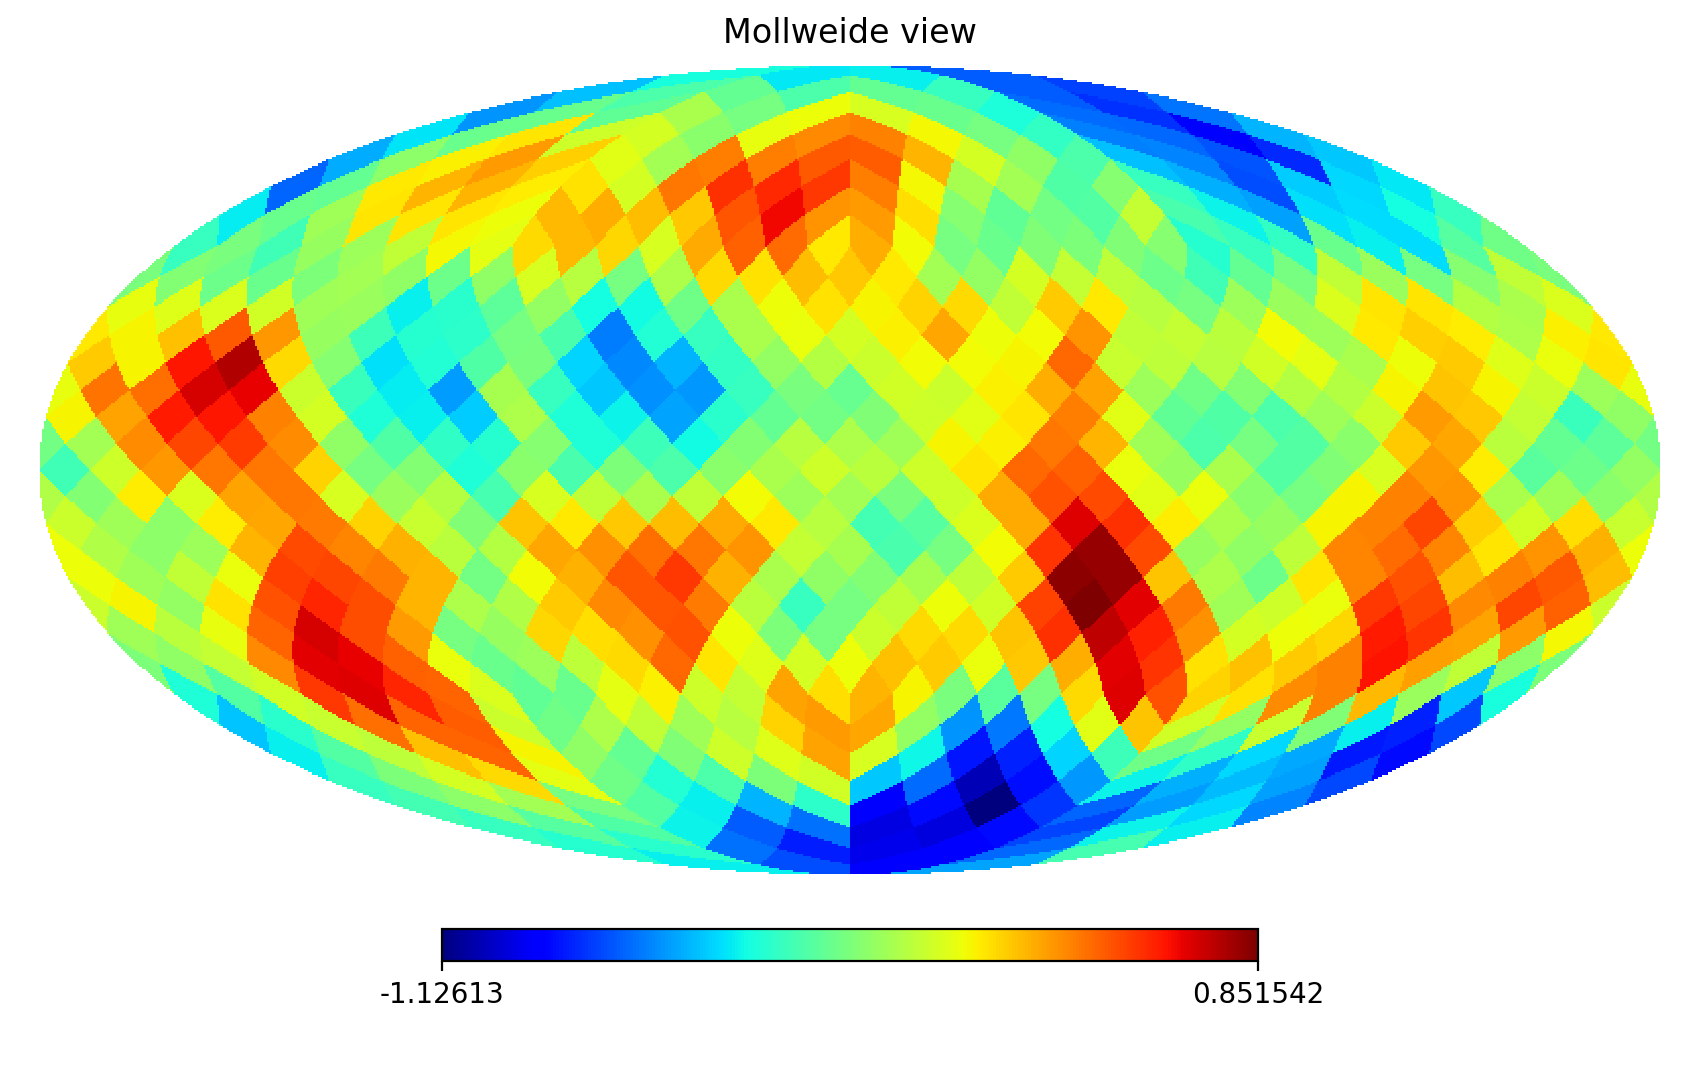

<IPython.core.display.Javascript object>


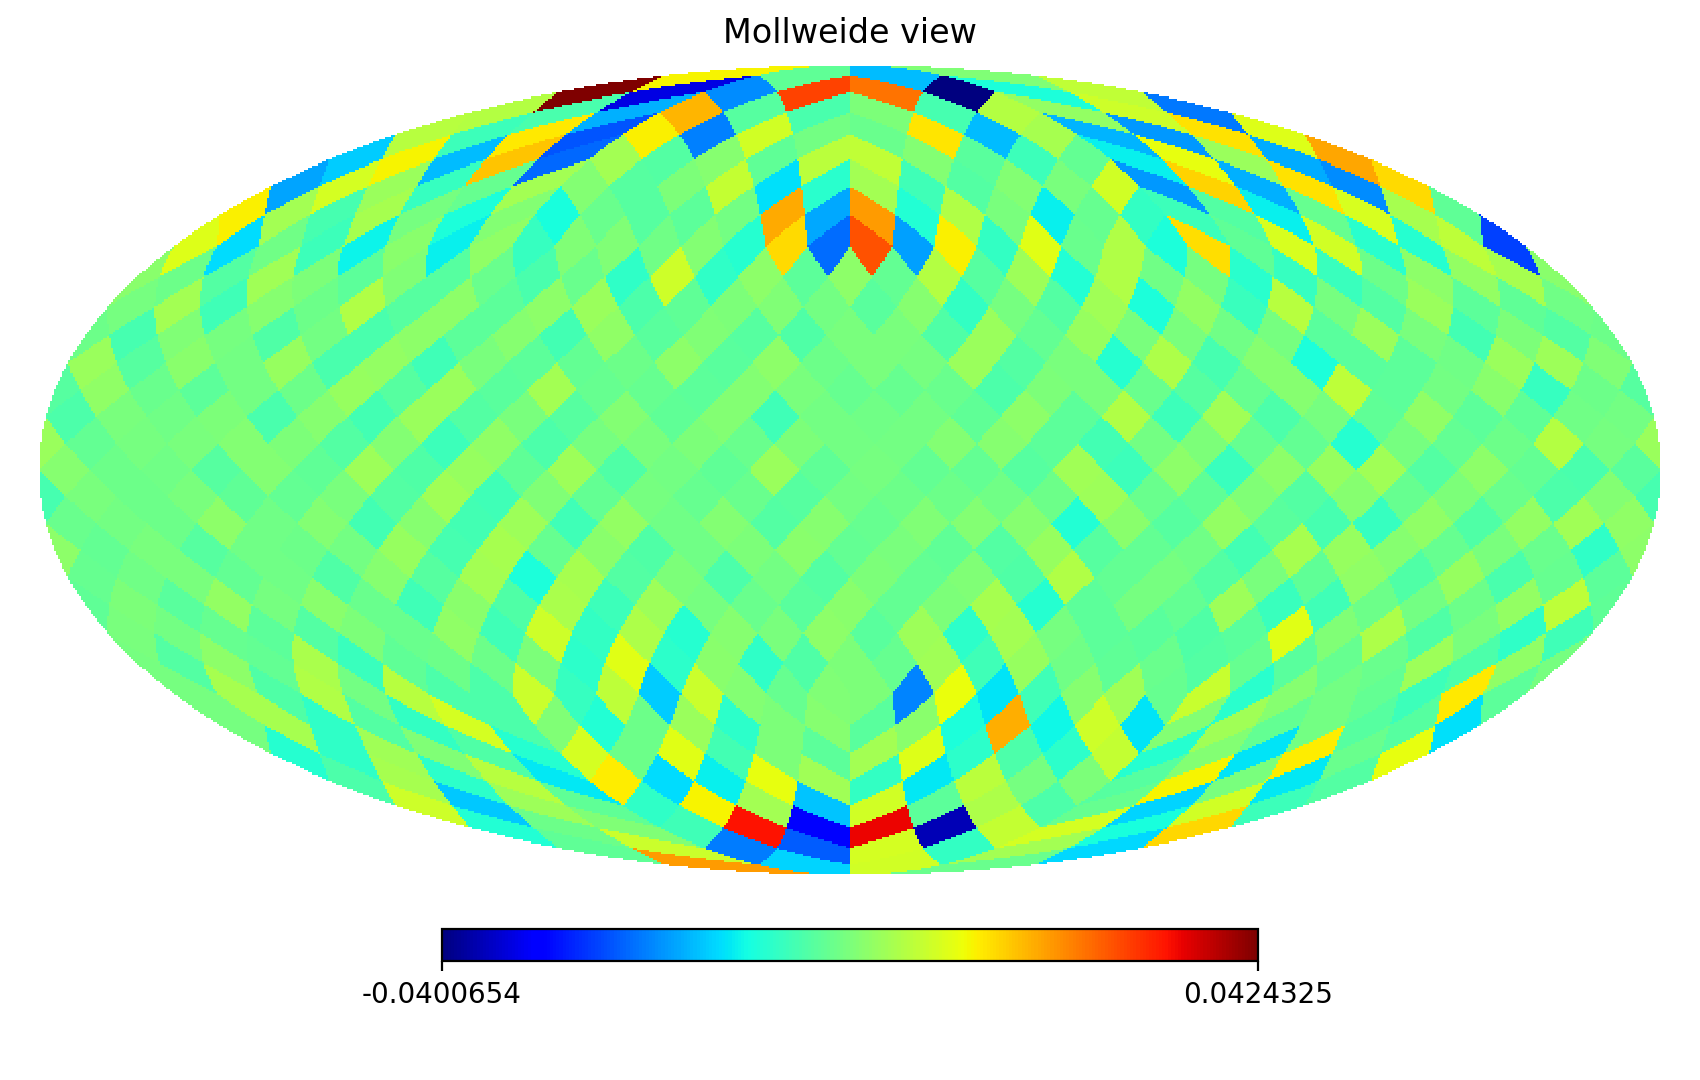

<IPython.core.display.Javascript object>


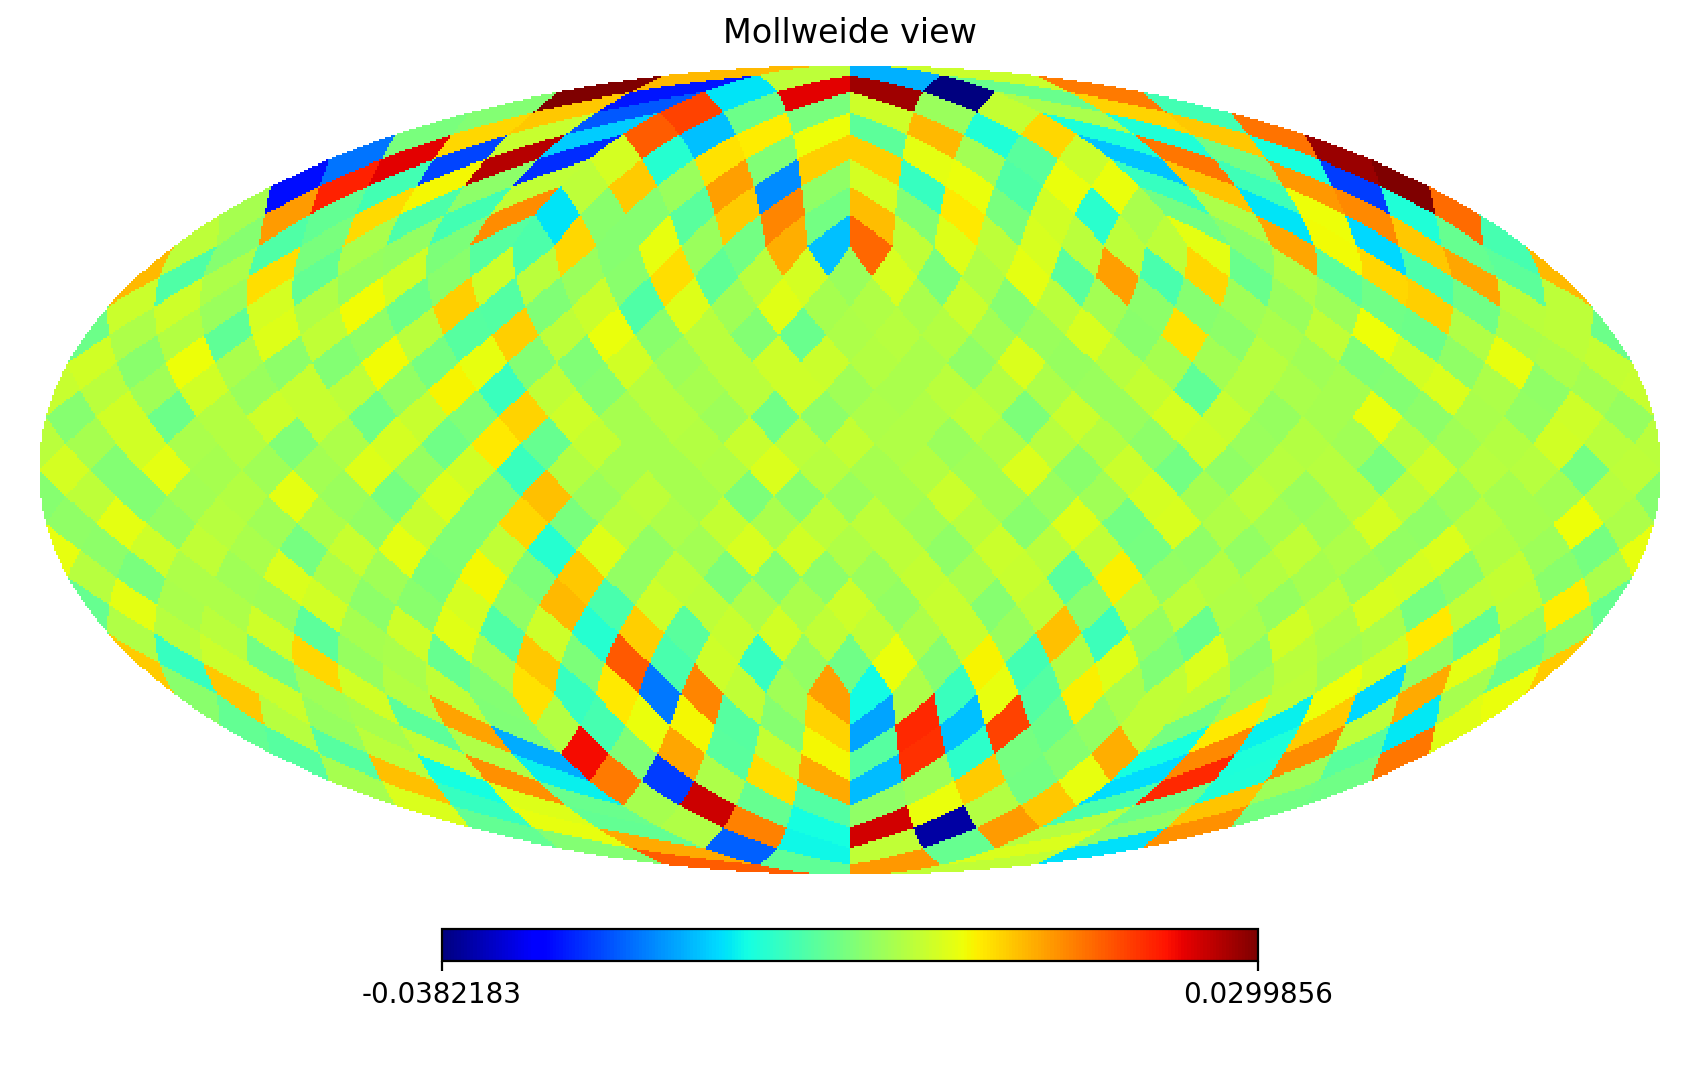

In [43]:
h.mollview(teb[1])
h.mollview(teb2[1])
h.mollview(teb[2])
h.mollview(teb2[2])